# Assignment 6

**Submission deadline:**

* **Problem 1 is due last lab session before or on Wednesday, 31.01.18**

* **Bonus problems are due Wednesday, 7.02.18**

Lecture on SVM (necessary for solving bonus problems 4-7) will take place on Saturday, 27.01.2018 from 10am - 2pm in room 119.

**Points: 4 + 11 bonus points**


## Downloading this notebook

This assignment is an Jupyter notebook. Download it by cloning https://github.com/janchorowski/nn_assignments. Follow the instructions in its README for instructions.

Please do not hesitate to use GitHub’s pull requests to send us corrections!

In [1]:
%pylab inline
import os

Populating the interactive namespace from numpy and matplotlib


# Problem 1: Word Embeddings [4p]

Many natural language processing tasks requrie continuous representations for words.
[Word embeddings](https://en.wikipedia.org/wiki/Word_embedding) are mappings from a discrete
space to real-valued vectors. Word embeddings might be trained with neural networks,
either as a by-product of other tasks (e.g., language modeling, neural machine translation),
or with networks designed specifically for the word embedding task.

Two problems associated with training neural word embeddings are related to the speed of training:
(a) large volume of data, on which the network has to be trained on, and (b) time required to compute
output probability distribution over large vocabularities.

One of the most popular architectures for training word embeddings is called Word2vec [[1]()], [[2]()]. It builds on the idea that semantics of a word can be defined through the contexts,
in which the word appears in the sentence.

Let $w_1, w_2,\ldots,w_N$ be an $N$-word sentence in a natural language.
We define a context of a word $w_l$ a list of $n$ preceeding and following words
$w_{l-n},\ldots,w_{l-1},w_{l+1},\dots,w_{l+n}$.

The underlying assumption is that similar words appear in similar contexts.
For instance, words *Poland* and *Monaco* are similar in a sense, that they are singular nouns
describing abstract concepts of existing, european countries.
We can convince ourselves by looking at exceprts from Wikipedia articles
on Poland and Monaco:

* Despite **Monaco's independence** and separate foreign policy
* aimed to preserve **Poland's independence** and the szlachta's

* **Monaco joined the** Council of Europe in 2004
* **Poland joined the** Schengen Area in 2007

* nearly one-fifth **of Poland's population** – half of them
* Christians comprise a total of 83.2% **of Monaco's population**.

### Task
You will use word vectors pre-computed on a large dataset.
* **[1p]** It has been observed, that word embeddings allow to perform semantic arithmetic where, for instance

    **king** - **man** + **woman** ~= **queen**

    This *analogy* task is often used as a quality measure of word embeddings. Load word embeddings and compute
    their analogy score on a dataset of analogous pairs, expressed as an accuracy of accuracy of predicting a pair
    item (**queen** in the example above). Specifically, compare `FastText` and `Word2vec` word embeddings.
    
* **[1p]** Word embedding capture approximate semantics. Under an assumption that words of similar semantics
    exist in different languages, a mapping $W: \mathbb{R}^{300}\mapsto\mathbb{R}^{300}$ might be constructed that
    translates word embeddings between languages. It has been shown that such ortonormal mappings allow to express
    approximate, bilingual dictionaries. In addition, non-linear mappings do not offer additional benefits.

    Given a simple English-Polish dictionary of word pairs (sourced from Wikitionary)
    find an orthonormal mapping $W$ between English and Polish `FastText`
    word embeddings using Procrustes analysis.

* **[1p]** Word embeddings can often be nicely visualized.
    Make a 2-D `PCA` plot of word embeddings for countries and their capital cities
    for `FastText` or `Word2vec`. Connect each country with its capital city with a line segment.
    Can you see any regularities?
    
* **[1p]** Plot 400 roughly most frequent words' embeddings (either `FastText` or `Word2vec`) in 2-D with `PCA`.
    Skip stop words, punctuations, artifact words, etc. You can be imprecise and use heuristics
    (e.g., select words than are at lest 3 charactes long).
    Can you see any regularities? Another method of making meaningful visualizations is `t-SNE`.
    
    Make another 2-D visualization, this time using `t-SNE`. Visualizations with `t-SNE` are obtained
    with gradient descent. Try to tweak optimization parameters to get lower optimization error,
    than the one with default parameters.
    Can you see any regularities this time?

## Subtask 1: Analogies

In [2]:
import codecs

import numpy as np
from scipy.linalg import orthogonal_procrustes
from scipy.spatial import distance

import tabulate


def load_fasttext(vec_fpath, n):
    words, vecs = [], None
    with codecs.open(vec_fpath, 'r') as f:
        for i, line in enumerate(f):
            if i == 0:
                total, dims = [int(d) for d in line.strip().split()]
                vecs = np.zeros((n, dims), dtype=np.float32)
            if i >= n:
                break
            word, vec_s = line.strip().split(' ', 1)
            words.append(word)
            vecs[i] = np.fromstring(vec_s, dtype=np.float32, sep=' ')
    return vecs, words

def load_analogies():
    '''Load tuples of analogies, e.g., (man, woman, king, queen)'''
    questions_path = os.path.join(os.environ['PYTORCH_DATA_PATH'],
                              'word2vec_eval/questions-words.txt')
    analogies = [l.strip().split() for l in open(questions_path, 'r') \
                 if not l.startswith(':')]
    return analogies

In [3]:
# Load top 200k word embeddings: Word2vec and FastText
word2vec = np.load(os.environ['PYTORCH_DATA_PATH'] + '/word2vec/word2vec_GoogleNews_200k.npy')
word2vec_vocab = [l.strip() for l in codecs.open(
                  os.environ['PYTORCH_DATA_PATH'] + '/word2vec/word2vec_GoogleNews_200k.txt', 'r', 'utf-8')]
word2vec_word2idx = {w:i for (i,w) in enumerate(word2vec_vocab)}

ftext, ftext_vocab = load_fasttext(os.environ['PYTORCH_DATA_PATH'] + '/fasttext/wiki.en.vec', n=200000)
ftext_word2idx = {w:i for (i,w) in enumerate(ftext_vocab)}

In [4]:
def eval_analogies(word_vecs, words, analogies):
    """
    Compute the accuracy on the analogy task.
    
    In the task, quadruples of words are given (q1, q2, r1, r2).
    The words q1 and q2 are bound by a relation. The words r1 and r2 
    are bound by the same relation. The task is to predict r2 knowing words
    q1, q2, and r1.
    
    Example:
    Quadruple [King, Queen, Man, Woman] yields the question
    King is to Queen as Man is to ????
    
    Args:
        word_vecs: float32 array with shape num_words x dim
        words: list of strings with size num_words
        analogies: list of quadruples: (q1, q2, r1, r2)
        
    Returns:
        percentage of correct answers
    """
    word2idx = {w:i for i,w in enumerate(words)}
    indexes = [[word2idx.get(w, None) for w in tupl] \
                for tupl in analogies]
    indexes = [tupl for tupl in indexes \
               if all([v is not None for v in tupl])]
    
    
    # indexes holds quadruples of ints giving the ids of words from our vocab.
    indexes = np.asarray(indexes)
    print 'Got vocab for %d/%d pairs' % (indexes.shape[0], len(analogies))
    
    
    # Extract the vectors for the query words
    q1 = word_vecs[indexes[:, 0]]
    q2 = word_vecs[indexes[:, 1]]
    r1 = word_vecs[indexes[:, 2]]
    
    # Extractr the word IDs for the correct answers
    r2_inds = indexes[:, 3]
    
    # Compute the approximate location of word r2 as r2 = r1 + (q2 - q1)
    # Find the word closest to this location using cosine distance.
    # Return it's id and compute the accurracy.
    r2 = r1 + (q2 - q1)
    distances = distance.cdist(r2, word_vecs, 'cosine')
    r2_pred_inds = np.argmin(distances, axis=1)
    return 100.0 * (r2_pred_inds == r2_inds).sum() / r2_inds.shape[0]

In [5]:
# Load analogy tuples, e.g., (man, woman, king, queen)
analogies = load_analogies()

# Some are uppercased geographical names (and FastTexts are lowercased)
analogies_lower = [[w.lower() for w in tupl] for tupl in analogies]

print analogies[0]
print analogies_lower[0]

['Athens', 'Greece', 'Baghdad', 'Iraq']
['athens', 'greece', 'baghdad', 'iraq']


In [41]:
# Keep in mind that the vocab is restricted to 200k most freq words
# (in the training corpus!)
print 'FastText analogy task accuracy:'
print '-------------------------------'
print eval_analogies(ftext, ftext_vocab, analogies_lower), '%'

print '\nWord2vec analogy task accuracy:'
print '-------------------------------'
print eval_analogies(word2vec, word2vec_vocab, analogies), '%'
print eval_analogies(word2vec, word2vec_vocab, analogies_lower), '%'

FastText analogy task accuracy:
-------------------------------
Got vocab for 19420/19544 pairs
16.3697219361 %

Word2vec analogy task accuracy:
-------------------------------
Got vocab for 18783/19544 pairs
20.8592876537 %
Got vocab for 9574/19544 pairs
14.3304783789 %


## Subtask 2: translation through alignment of vector spaces

In [6]:
import mkl
mkl.get_max_threads()
# We're gonna need Polish embeddings
ftext_pl, ftext_pl_vocab = load_fasttext(os.environ['PYTORCH_DATA_PATH'] + '/fasttext/wiki.pl.vec', n=200000)
ftext_pl_word2idx = {w:i for (i,w) in enumerate(ftext_pl_vocab)}

# Load a simple wikitionary-based dict of word pairs
path = os.environ['PYTORCH_DATA_PATH'] + '/word2vec_eval/word2vec_en_pl'
en_pl = [l.strip().split('\t') for l in codecs.open(path, 'r', 'utf-8') \
         if not '<UNK>' in l]
en_pl = {t[0]:t[1] for t in en_pl if len(t) == 2}

# Keep those, for which we have embeddings
en_pl = {en:pl for (en,pl) in en_pl.items() \
         if en in ftext_word2idx and pl in ftext_pl_word2idx}
print 'Dictionary size:', len(en_pl)
print 'good --', en_pl['good']

Dictionary size: 464
good -- dobro


In [7]:
# Select word embeddings for dictionary words
en_words = sorted(en_pl.keys())
V_en = ftext[[ftext_word2idx[w] for w in en_words]]
V_pl = ftext_pl[[ftext_pl_word2idx[en_pl[w]] for w in en_words]]
print V_en.shape, V_pl.shape

(464, 300) (464, 300)


In [12]:
# Find an orthogonal transformation from V_en to V_pl.
# which minimizes square reconstruction error

# Hint: use scipy.linalg import orthogonal_procrustes
W, scale = orthogonal_procrustes(V_en, V_pl)

In [16]:
((V_en.dot(W) - V_pl)**2).sum()

4319.6187

In [9]:
def translate(W, v, vecs2, vocab2):
    # Transform source word vector v using W getting a location in target space.
    # Find the closest word in target space using the cosine distance.
    translated = np.dot(v,W) #sprzeczne z intuicją?? ale w drugą stronę nie działa 
    distances = distance.cdist(translated[None,:], vecs2, 'cosine')
    idx = np.argmin(distances)

    return vocab2[idx]

# Select random, fairly frequent words not from the dictionary
tr_words = [i for i in np.random.randint(2000, 5000, 100) \
            if not en_pl.has_key(ftext_vocab[i])]
tr_words = tr_words[:20]

rows = [[ftext_vocab[i], translate(W, ftext[i], ftext_pl, ftext_pl_vocab)] \
         for i in tr_words] 
rows = [[r.decode('utf-8') for r in row] for row in rows]
print tabulate.tabulate(rows).encode('utf-8')

-----------  -------------
pushpin_map  rakietowe
buried       pochował
suspended    zawieszony
climate      klimatyczny
viewed       postrzegany
hms          teja
warned       interweniował
disney       filmu
jimmy        klenczon
waiting      czekających
queensland   fremont
fields       pole
golf         golfowy
arab         „wojna
ie           °°d°
nfl          dywizja#grupa
warren       betts
lots         mnóstwo
spirit       szepty
shanghai     dearborn
-----------  -------------


## Subtask 3: PCA

In [37]:
path = os.environ['PYTORCH_DATA_PATH'] + '/word2vec_eval/countries_capitals'
capitals = [l.strip().split('\t') for l in codecs.open(path, 'r', 'utf-8')]
capitals = {country:capital for (country,capital) in capitals}

# Select those present in Word2vec vocab
capitals = {k:v for (k,v) in capitals.items() \
            if k in word2vec_word2idx and v in word2vec_word2idx}

# Flatten the array to have a list of [country, capital, country, capital, ...]
geo = [e for pair in capitals.items() for e in pair]
print len(geo) // 2, 'pairs', geo[:6]

131 pairs [u'Canada', u'Ottawa', u'Turkmenistan', u'Ashgabat', u'Lithuania', u'Vilnius']


In [10]:
geo_inds = [word2vec_word2idx[w] for w in geo]
geo_vecs = word2vec[geo_inds]
print geo_vecs.shape

(262, 300)


(262, 2)


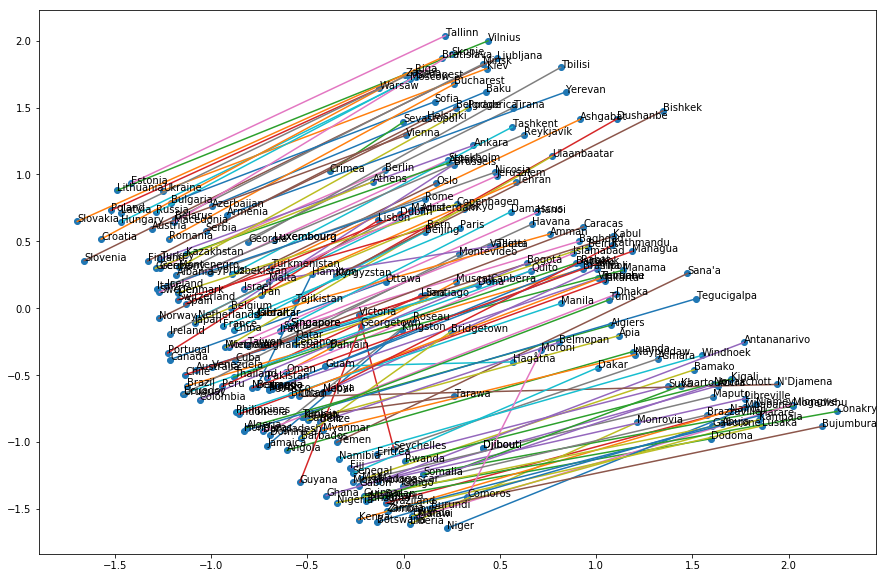

In [49]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
geo_rot = pca.fit(geo_vecs).transform(geo_vecs)
print geo_rot.shape

# use PCA from sklearn.decomposition to project the countries and capitals into 2D.
# draw lines connecting each country with its capital
#
# Hint:
# - the function "annotate" can be used to put text onto the plot

fig = figure(figsize=(15,10))
ax = fig.add_subplot(111)
my_plot = ax.scatter(geo_rot[:,0], geo_rot[:,1])
for i in range(len(geo)):
    ax.annotate(geo[i], geo_rot[i,:])
for i in range(0,len(geo),2):
    ax.plot(geo_rot[i:(i+2),0], geo_rot[i:(i+2),1])
show()


## Subtask 4: PCA vs t-SNE on frequent words

(400, 2)


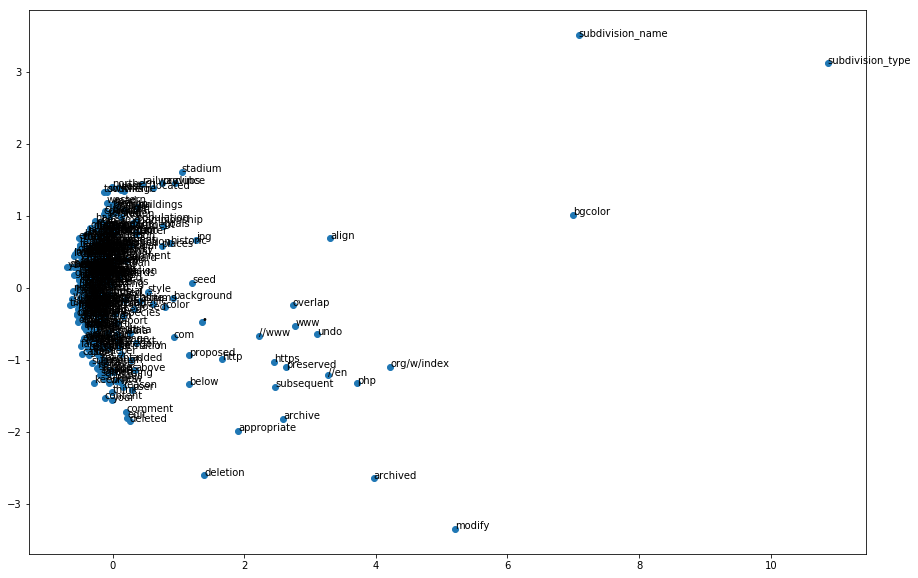

In [56]:
# Select words starting from the 200th to ommit stop words,
# which have at least 3 chars
top_words = [w for (i,w) in enumerate(ftext_vocab) \
             if i > 200 and len(w) >= 3][:400]
top_inds = [ftext_word2idx[w] for w in top_words]

top_vecs = ftext[top_inds]

#make a 2D PCA projection of the selected words
pca = PCA(n_components=2)
top_rot = pca.fit(top_vecs).transform(top_vecs)
print top_rot.shape
fig = figure(figsize=(15,10))
ax = fig.add_subplot(111)
my_plot = ax.scatter(top_rot[:,0], top_rot[:,1])
for i in range(len(top_words)):
    ax.annotate(top_words[i].decode('utf-8'), top_rot[i,:])
show()

(400, 2)


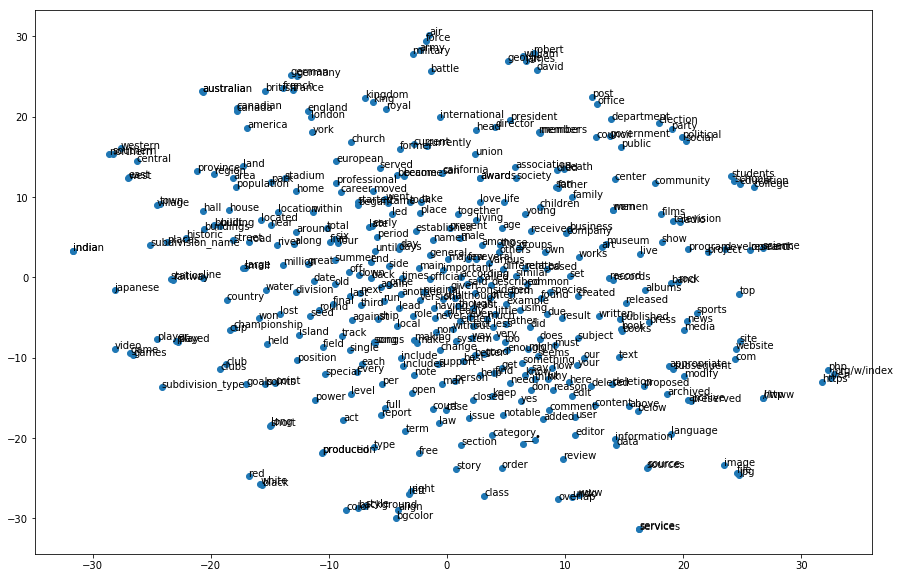

In [58]:
from sklearn.manifold import TSNE
# make a 2D t-SNE projection of the selected words.
top_tsne = TSNE(n_components=2).fit_transform(top_vecs)
print top_tsne.shape
fig = figure(figsize=(15,10))
ax = fig.add_subplot(111)
my_plot = ax.scatter(top_tsne[:,0], top_tsne[:,1])
for i in range(len(top_words)):
    ax.annotate(top_words[i].decode('utf-8'), top_tsne[i,:])
show()

# Problem 2: K-Means [2p bonus]

Fill in the blanks in the K-means code. Then compare the following 3 strategies for initial point selection

1. Uniform sampling over the range of the data
2. Uniform sampling of data points
3. Kmeans++ (http://ilpubs.stanford.edu:8090/778/1/2006-13.pdf, pg. 3):
    1. the first point is sampled uniformly from the dataset
    2. subsequent points are sampled with probability $\frac{D(x)^2}{\sum_{x'} D(x')^2}$, where $D(x)$ denotes the distance from $x$ to a nearest point that was already chosen. 
    
Conduct experiments for various number of clusters and different initialization strategies. Make screenshots of some representative solutions (and failure modes).

Make one cluster of the generated data much 3-5 times larger. How does it affect the K-means solution?

(2, 80)


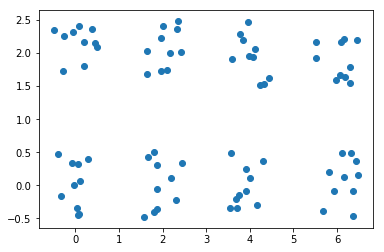

In [59]:
def gen_cluster(x0, y0, n=20):
    return np.random.rand(2,n) + np.array([[x0],[y0]]) - 0.5

def gen_data():
    clusters = []

    for x in [0,2,4,6]:
        for y in [0,2]:
            n = 10
            clusters.append(gen_cluster(x,y,n))

    return np.hstack(clusters)

data = gen_data()
scatter(data[0,:], data[1,:])
print data.shape

In [60]:
def dist(X,Y):
    print X.shape, Y.shape
    dd = X[:,None,:] - Y[:,:,None]
    print dd.shape
    dd = (dd**2).sum(0)
    print dd.shape
    return dd

In [74]:
k_means(data,8, init_pts='km++')

(2, 1)
(2, 1) (2, 80)
(2, 80, 1)
(80, 1)
(80, 1)


In [73]:
def k_means(data, k, init_pts='rand_samples'):
    dim, ns = data.shape
    
    if init_pts == 'rand_samples':
        C = data[:,np.random.randint(0, data.shape[1], k)]
        print C.shape
    elif init_pts == 'rand_range':
        C = np.array([np.random.uniform(np.min(data[0,:]), np.max(data[0,:]), k), \
                      np.random.uniform(np.min(data[1,:]), np.max(data[1,:]), k)])
        print C.shape
    elif init_pts == 'km++':
        C =  np.array(data[:, np.random.randint(0, data.shape[1])], ndmin=2).reshape((2,1))
        print C.shape
        while C.shape[1] < k:
            distances = dist(C,data)
            print distances.shape
            break
            
    else:
        raise Exception('invalid init_pts!')
    return
    
    Cinit = C.copy()
    last_assignments = np.zeros((ns,))
    while True:
        D = dist(data, C)
        assignment = TODO

        for ci in xrange(k):
            sel = assignment==ci
            if sum(sel) == 0:
                print 'empty cluster: ', ci, '!'
                C[:,ci] = np.inf
            else:
                C[:,ci] = TODO
        if np.all(assignment == last_assignments):
            break
        last_assignments = assignment
        break
    
    return assignment, C, Cinit

In [ ]:
colormap = [
    (0.5529411764705883, 0.8274509803921568, 0.7803921568627451),
    (1.0, 1.0, 0.7019607843137254),
    (0.7450980392156863, 0.7294117647058823, 0.8549019607843137),
    (0.984313725490196, 0.5019607843137255, 0.4470588235294118),
    (0.5019607843137255, 0.6941176470588235, 0.8274509803921568),
    (0.9921568627450981, 0.7058823529411765, 0.3843137254901961),
    (0.7019607843137254, 0.8705882352941177, 0.4117647058823529),
    (0.9882352941176471, 0.803921568627451, 0.8980392156862745)]


a, c, cinit = k_means(data, 8, init_pts='km++')

for ci in set(a):
    scatter(data[0,a==ci],data[1,a==ci], color=colormap[ci], s=25)

scatter(cinit[0,:], cinit[1,:], color='k',marker='*', s=40)
scatter(c[0,:], c[1,:], color='k',marker='v', s=25)

# Problem 3: Bisecting K-Means [2p bonus]

Implement the "Bisecting k-means" algorithm, such as the one from Apache Spark: https://spark.apache.org/docs/1.6.0/api/java/org/apache/spark/mllib/clustering/BisectingKMeans.html.

# SVM Bonus Exercises

In [28]:
import numpy as np
import pandas

import cvxopt
from sklearn import svm

## Installing dependencies
  
When using lab computers, you are all set :)

When using your home computer you need to install CVXOPT
(Python Software for Convex Optimization):
1. for Linux Anaconda python you can install cvxopt running `conda install cvxopt`.
2. On Windows download a package from http://www.lfd.uci.edu/~gohlke/pythonlibs/\#cvxopt. Under
  WinPython, you can use the WinPython control panel to intall the
  package. On Anconda simply unzip the downloaded file (it's a zip
  file in disguise) and place the contents somewhere under your
  PYTHONPATH environment variable.

# SVM Theory
A linear SVM assigns points $x^{(i)}\in\mathbb{R}^n$ to one of two
classes,  $y^{(i)}\in\{-1,1\}$ using the decision rule:

\begin{equation}
y = \text{signum}(w^T x + b).
\end{equation}

SVM training consists of finding weights $w\in\mathbb{R}^n$
and bias $b\in\mathbb{R}$ that maximize the separation margin. This
corresponds to solving the following quadratic optimization problem:

\begin{equation}
\begin{split}
  \min_{w,b,\xi}  &\frac{1}{2}w^Tw  + C\sum_{i=1}^m \xi_i  \\
  \text{s.t. } & y^{(i)}(w^T x^{(i)} + b) \geq 1- \xi_i\;\; \forall_i \\
  & \xi_i \geq 0 \;\; \forall_i.
\end{split}
\end{equation}

# Problem 4 [1p bonus]

Load the iris dataset. Using the `sklearn.svm.SVC` library train a linear SVM that
separates the Virginica from the Versicolor class using the
petal length and petal width features. Plot the obtained decision boundary and
the support vectors (their locations and weights - coefficients $\alpha$).
  
  

Features:  ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
Targets:  Shape: (3,)
['setosa' 'versicolor' 'virginica']


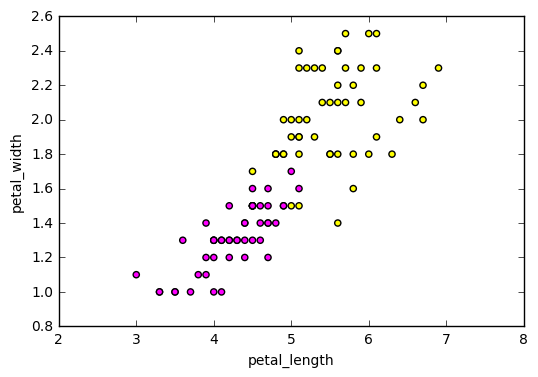

In [5]:
# load iris, extract petal_length and petal_width of versicolors and virginicas

from sklearn import datasets
iris = datasets.load_iris()
print 'Features: ', iris.feature_names
print 'Targets: ', iris.target_names
petal_length = iris.data[:,iris.feature_names.index('petal length (cm)')]
petal_width = iris.data[:, iris.feature_names.index('petal width (cm)')]

IrisX = np.array(iris.data.T)
IrisX = IrisX[:, iris.target!=0]

IrisX2F = np.vstack([petal_length, petal_width])
IrisX2F = IrisX2F[:, iris.target!=0]

# Set versicolor=0 and virginia=1
IrisY = (iris.target[iris.target!=0]-1).reshape(1,-1).astype(np.float64)

scatter(IrisX2F[0,:], IrisX2F[1,:], c=IrisY.ravel(), cmap='spring')
xlabel('petal_length')
ylabel('petal_width')

In [8]:
#
# Fit a linear SVM using libsvm
#

svm_model = TODO
svm_model.fit(TODO)

print "libsvm error rate: %f" % ((svm_model.predict(IrisX2F.T)!=IrisY).mean(),)

libsvm error rate: 0.050000


In [ ]:
#
# Plot the decision boundary
#

petal_lengths, petal_widths = np.meshgrid(np.linspace(IrisX2F[0,:].min(), IrisX2F[0,:].max(), 100),
                                          np.linspace(IrisX2F[1,:].min(), IrisX2F[1,:].max(), 100))

IrisXGrid = np.vstack([petal_lengths.ravel(), petal_widths.ravel()])
predictions_Grid = svm_model.predict(IrisXGrid.T)

contourf(petal_lengths, petal_widths, predictions_Grid.reshape(petal_lengths.shape), cmap='spring')
scatter(IrisX2F[0,:], IrisX2F[1,:], c=IrisY.ravel(), cmap='spring')

xlabel('petal_length')
ylabel('petal_width')
title('Decision boundary found by libsvm')

In [ ]:
#
# Plot the decision boundary and the support vectors.
#
# You can extract the indices of support vectors and their weights from fielfs of the 
# svm object. Display the loaction of support vectors and their weights (by changing the 
# size in the scatterplot)


support_vector_indices = TODO
support_vector_coefficients = TODO

contourf(petal_lengths, petal_widths, predictions_Grid.reshape(petal_lengths.shape), cmap='spring')
scatter(TODO,
        cmap='spring')

xlabel('petal_length')
ylabel('petal_width')
title('Decision boundary found by libsvm')

# Problem 5 [1p bonus]

Reimplement the linear SVM using the use `cvxopt.solvers.qp`
Quadratic Programming (QP) solver. You will need to define the matrices
that define the problem. Compare the obtained solutions. Extract the
support vectors from the LIBSVM solution and plot the support vectors.

The `cvxopt.solvers.qp` solves the following optimization problem: 

\begin{align}
\text{minimize over } x \text{: }& \frac{1}{2} x^T P x + q^T x \\
\text{subject to: } & Gx \leq h \\
& Ax = b
\end{align}

To solve the SVM problem you need to encode the weights $W$, biases $b$, and slack variables $\xi$ as elements of the vector $x$, then properly fill the matrices and vectors $P$, $q$, $G$, $h$. We can ignore setting the $A$ and $b$ parametrs, since there are no linear constraints.

In [ ]:
#
# Now solve the SVM using the QP solver
#

n, m = IrisX2F.shape
C=10.0

P = np.zeros((n+1+m, n+1+m)) #w, bias, xi
q = np.zeros((n+1+m,1)) 
G = np.zeros((2*m, n+1+m)) # we have two ocnstrains fot each data point: 
                           # that the margin is equal to 1-xi
                           # and that xi is nonnegative
h = np.zeros((2*m,1))
#
# TODO: fill in P, q, G, h
#

TODO

#
# Now run the solver
#
ret  = cvxopt.solvers.qp(cvxopt.matrix(P), cvxopt.matrix(q), 
                         cvxopt.matrix(G), cvxopt.matrix(h), )

ret = np.array(ret['x'])

#
# extract the weights and biases
#
W = ret[:n].reshape(-1,1)
b = ret[n]

#
# Extract the weight and bias from libsvm for comparison
#
Wlibsvm = TODO
blibsvm = TODO

print 'W', W.T, 'Wlibsvm', Wlibsvm
print 'b', b, 'blibsvm', blibsvm

In [ ]:
#
# Plot the decision boundary obtained with QP
#

predictions_QP_Grid = (W.T.dot(IrisXGrid) + b)>0.0

print predictions_QP_Grid.shape

contourf(petal_lengths, petal_widths, 
         predictions_QP_Grid.reshape(petal_lengths.shape), cmap='spring')
scatter(IrisX2F[0,:], IrisX2F[1,:], c=IrisY.ravel(), cmap='spring')

xlabel('petal_length')
ylabel('petal_width')
title('Decision boundary found by QP solver')

# Problem 6 [2p bonus]

Repeat 100 bootstrap experiments to establish the effect of constant $C$ on SVM.

For each experiment do the following:

1. Sample (with replacement) a bootstrap dataset equal in size to the
    training dataset. This will be this experiment's training dataset.
2. Prepare the experiment's testing dataset by using samples not
    inluded in the bootstrap dataset.
3. For all $C$ from the set $\{10^{-4}, 10^{-3.5}, 10^{-3.}, \ldots, 10^{6}\}$
    fit a nonlinear SVM (Gaussian kernel, called \texttt{rbf} in
    LIBSVM using the default $\gamma$) and record the training and
    testing errors.

Analyze a box plot of errors as a function of $C$. Can you see its
influence on the training and testing error, as well as on the
testing error variability? Indicate regions of overfitting and underfitting.



In [ ]:
res = []
for rep in xrange(100):
    bootstrap_sel = TODO
    test_sel = TODO

    bootstrap_IrisX = IrisX[:,bootstrap_sel]
    bootstrap_IrisY = IrisY[:,bootstrap_sel]
    
    test_IrisX = IrisX[:,test_sel]
    test_IrisY = IrisY[:,test_sel]
    
    #
    # TODO: Loop over a list of exponents.
    #
    for Cexponent in TODO:
        C = 10.0**Cexponent
        svm_model = TODO
        svm_model.fit(TODO)
        train_acc = TODO
        test_acc = TODO
        
        res.append(dict(Cexponent=Cexponent, test_err=1-test_acc, train_err=1-train_acc))

res = pandas.DataFrame(res)
figure(figsize=(20,10))
res.boxplot(['test_err','train_err'], 'Cexponent', rot=90)

# Problem 7 [3p bonus]

Implement a nonlinear SVM by solving the dual problem using the Quadratic Programming solver. Compare results with LIBSVM.